# Simulation experiment for detection thresholds for variant calling

This notebook is to get detection thresholds for the limit of the variant calling based on: 

1. Read depth
2. Error rate
3. Number of mutations

The data from this comes from: https://pubs.acs.org/doi/10.1021/acscentsci.7b00548 Ape AGW


In [43]:
import pandas as pd
# Visualisation things to make the figures look nice
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from sciutil import SciUtil


data_dir = 'ePCR_data/'
fig_dir = 'ePCR_figures/'


plt.rcParams['svg.fonttype'] = 'none'
axis_line_width = 1.0
axis_font_size = 12
title_font_size = 12
label_font_size = 10
figsize = (2.5, 3) # Figure size
font = 'Arial'
style = 'ticks'
font_family = 'sans-serif'

# Create a figure with 2x2 subplots
cmap = 'viridis'
palette = sns.color_palette("viridis_r", as_cmap=True)
sns.set_palette(cmap)

sns.set(rc={'figure.figsize': figsize, 'font.family': font_family,
            'font.sans-serif': font, 'font.size': label_font_size}, style=style)
sns.set_style("ticks")

def set_ax_params(ax):
    ax.tick_params(direction='out', length=2, width=axis_line_width)
    ax.spines['bottom'].set_linewidth(axis_line_width)
    ax.spines['top'].set_linewidth(0)
    ax.spines['left'].set_linewidth(axis_line_width)
    ax.spines['right'].set_linewidth(0)
    ax.tick_params(labelsize=axis_font_size)
    ax.tick_params(axis='x', which='major', pad=2.0)
    ax.tick_params(axis='y', which='major', pad=2.0)
    ax.tick_params(labelsize=label_font_size)


u = SciUtil()

# Generate mutations on a "real" sequence
# Decided to choose tauD from Ecoli K12
parent_sequence_aa = 'MTPSDIPGYDYGRVEKSPITDLEFDLLKKTVMLGEKDVMYLKKACDVLKDQVDEILDLAGGWVASNEHLIYYFSNPDTGEPIKEYLERVRARFGAWILDTTCRDYNREWLDYQYEVGLRHHRSKKGVTDGVRTVPHIPLRYLIAWIYPITATIKPFLAKKGGSPEDIEGMYNAWFKSVVLQVAIWSHPYTKENDWLEHHHHHH*'

parent_sequence = 'ATGACTCCCTCGGACATCCCGGGATATGATTATGGGCGTGTCGAGAAGTCACCCATCACGGACCTTGAGTTTGACCTTCTGAAGAAGACTGTCATGTTAGGTGAAAAGGACGTAATGTACTTGAAAAAGGCGTGTGACGTTCTGAAAGATCAAGTTGATGAGATCCTTGACTTGGCGGGTGGTTGGGTAGCATCAAATGAGCATTTGATTTATTACTTCTCCAATCCGGATACAGGAGAGCCTATTAAGGAATACCTGGAACGTGTACGCGCTCGCTTTGGAGCCTGGATTCTGGACACTACCTGCCGCGACTATAACCGTGAATGGTTAGACTACCAGTACGAAGTTGGGCTTCGTCATCACCGTTCAAAGAAAGGGGTCACAGACGGAGTACGCACCGTGCCCCATATCCCACTTCGTTATCTTATCGCATGGATCTATCCTATCACCGCCACTATCAAGCCATTTTTGGCTAAGAAAGGTGGCTCTCCGGAAGACATCGAAGGGATGTACAACGCTTGGTTCAAGTCTGTAGTTTTACAAGTTGCCATCTGGTCACACCCTTATACTAAGGAGAATGACTGGCTCGAGCACCACCACCACCACCACTGA'

# Introduce mutations at a given frequency and an error rate

Test setup:

Change to 0.1 - 5% 0.2% step size. 

1. For number of mutations from 1 to the sequence length test mutating each one and correlate this to the p value
2. For sequencing error rates from 0 to 100% make sequences ranging with this and see what the results are for the p value and the error
3. For different sequence lengths also check how sequence length corresponds to the pvalue

In [44]:
from levseq import *
from tqdm import tqdm

label = 'ParLQ'

In [45]:
significance = -1*np.log10(0.001)

## Experiment 1: Varying the sequencing error rate for a single mutation

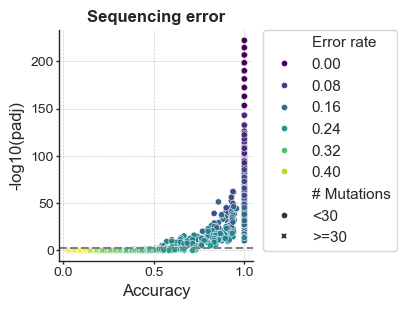

In [46]:

experiment_df = pd.read_csv(f'{data_dir}Experiment1_SeqError_{label}.csv')
experiment_df['-log10(P.adj)'] = -1*np.log10(experiment_df['P adj.'].values)
experiment_df['Error rate'] = [int(c.split('_')[-1])/100.0 for c in experiment_df['Plate']]
experiment_df['# Mutations'] = [len(v.split('_')) for v in experiment_df['Variant'].values]
experiment_df['# Mutations'] = [f'<30' if v < 30 else f'>=30' for v in experiment_df['# Mutations']]
experiment_df = experiment_df.reset_index()
ax = sns.scatterplot(experiment_df, x='accuracy', y='-log10(P.adj)', hue='Error rate', palette='viridis', 
                    style="# Mutations", style_order=['<30', '>=30'], s=20)
set_ax_params(ax)
plt.xlabel('Accuracy')
plt.ylabel('-log10(padj)')
plt.title('Sequencing error', fontsize=title_font_size, fontweight="bold")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.axhline(y = significance, color = 'grey', linestyle = '--') #axis='y', 
plt.grid(True, which='major', linestyle='--', linewidth=0.5)
plt.savefig(f'{fig_dir}Experiment1_SeqError_{label}.svg')
plt.show()

## Experiment 2: varying read depth and it's effect on significance

In [49]:
label

'ParLQ'

/var/folders/sj/4wqsfdtd6093v9746b0t3mq40000gn/T/ipykernel_83058/2601407418.py:2: RuntimeWarning: divide by zero encountered in log10
  experiment_df['-log10(P.adj)'] = -1*np.log10(experiment_df['P adj.'].values)


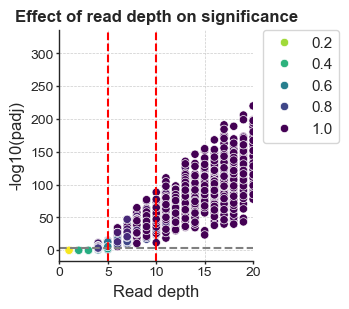

In [47]:
experiment_df = pd.read_csv(f'{data_dir}Experiment2_ReadDepth_{label}.csv')
experiment_df['-log10(P.adj)'] = -1*np.log10(experiment_df['P adj.'].values)
experiment_df['Read depth'] = [int(c.split('_')[-1]) for c in experiment_df['Plate']]
experiment_df['# Mutations'] = [len(v.split('_')) for v in experiment_df['Variant'].values]
experiment_df = experiment_df.reset_index()
experiment_df.replace([np.inf, -np.inf], 320, inplace=True)
ax = sns.scatterplot(experiment_df, x='Read depth', y='-log10(P.adj)', hue='accuracy', palette='viridis_r')
set_ax_params(ax)
plt.xlim((0, 20))
plt.xlabel('Read depth')
plt.ylabel('-log10(padj)')
plt.title('Effect of read depth on significance', fontsize=title_font_size, fontweight="bold")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.axhline(y = significance, color = 'grey', linestyle = '--') #axis='y', 
plt.grid(True, which='major', linestyle='--', linewidth=0.5)
plt.axvline(x = 5, color = 'red', linestyle = '--') #axis='y', 
plt.axvline(x = 10, color = 'red', linestyle = '--') #axis='y', 
plt.savefig(f'{fig_dir}Experiment2_{label}.svg')
plt.show()

In [48]:
f5_10 = experiment_df[experiment_df['Read depth'] > 10]
np.mean(f5_10['accuracy'].values)

0.9987150401702376

/var/folders/sj/4wqsfdtd6093v9746b0t3mq40000gn/T/ipykernel_83058/1558967847.py:2: RuntimeWarning: divide by zero encountered in log10
  experiment_df['-log10(P.adj)'] = -1*np.log10(experiment_df['P adj.'].values)


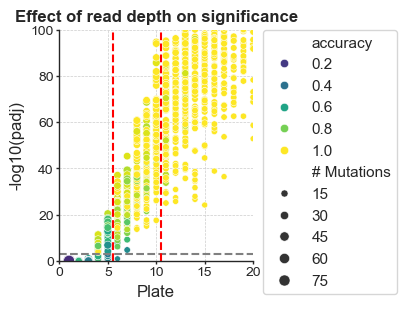

In [7]:
experiment_df = pd.read_csv(f'{data_dir}Experiment2_ReadDepth_{label}.csv')
experiment_df['-log10(P.adj)'] = -1*np.log10(experiment_df['P adj.'].values)
experiment_df['Plate'] = [int(c.split('_')[-1]) for c in experiment_df['Plate']]
experiment_df['# Mutations'] = [len(v.split('_')) for v in experiment_df['Variant'].values]
experiment_df = experiment_df.reset_index()
experiment_df.replace([np.inf, -np.inf], 320, inplace=True)

ax = sns.scatterplot(experiment_df, x='Plate', y='-log10(P.adj)', hue='accuracy', palette='viridis', 
                     size="# Mutations")
set_ax_params(ax)
plt.xlabel('Plate')
plt.ylabel('-log10(padj)')
plt.xlim((0, 20))
plt.ylim((0, 100))

plt.title('Effect of read depth on significance', fontsize=title_font_size, fontweight="bold")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.axhline(y = significance, color = 'grey', linestyle = '--') #axis='y', 
plt.axvline(x = 5.5, color = 'red', linestyle = '--') #axis='y', 
plt.axvline(x = 10.5, color = 'red', linestyle = '--') #axis='y', 

plt.grid(True, which='major', linestyle='--', linewidth=0.5)

plt.savefig(f'{fig_dir}Experiment2_version2_{label}.svg')
plt.show()

In [8]:
# Get for read depth between 0-5, 6-10, 10-20
for read_depth in range(1, 11):
    u.dp(['Read Depth:', read_depth, np.nanmean(experiment_df[experiment_df['Alignment_count'] == read_depth]['accuracy'].values)])

for read_depth in range(10, 90, 10):
    u.dp(['Read Depth:', read_depth, np.nanmean(experiment_df[experiment_df['Alignment_count'] == read_depth]['accuracy'].values)])


--------------------------------------------------------------------------------
                       Read Depth:	1	0.15033427254014373	                       
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
                        Read Depth:	2	0.638615523484963	                        
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
                       Read Depth:	3	0.41201416504051264	                       
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
                       Read Depth:	4	0.8531855774031181	                        
--------------------------------------------------------------------------------
----------------------------

/var/folders/sj/4wqsfdtd6093v9746b0t3mq40000gn/T/ipykernel_83058/3950413185.py:6: RuntimeWarning: Mean of empty slice
  u.dp(['Read Depth:', read_depth, np.nanmean(experiment_df[experiment_df['Alignment_count'] == read_depth]['accuracy'].values)])


## Experiment 3: effect of sequence length on significance


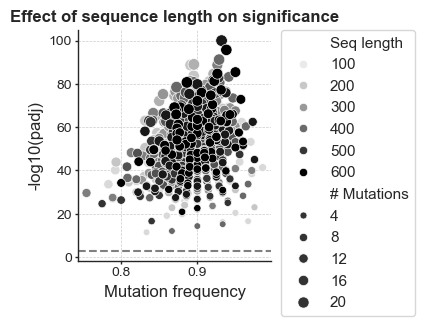

In [9]:
experiment_df = pd.read_csv(f'{data_dir}Experiment3_{label}.csv')

experiment_df['-log10(P.adj)'] = -1*np.log10(experiment_df['P adj.'].values)
experiment_df['Seq length'] = [int(c.split('_')[-1]) for c in experiment_df['Plate']]
experiment_df['# Mutations'] = [len(str(v).split('_')) for v in experiment_df['Variant'].values]
#experiment_df['# Mutations'] = [f'{v}' if v < 5 else f'>=5' for v in experiment_df['# Mutations']]
experiment_df = experiment_df.reset_index()
ax = sns.scatterplot(experiment_df, x='frequency', y='-log10(P.adj)', hue='Seq length', palette='Greys', 
                     size="# Mutations")#
set_ax_params(ax)
plt.xlabel('Mutation frequency')
plt.ylabel('-log10(padj)')
plt.title('Effect of sequence length on significance', fontsize=title_font_size, fontweight="bold")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.axhline(y = significance, color = 'grey', linestyle = '--') #axis='y', 
plt.grid(True, which='major', linestyle='--', linewidth=0.5)
plt.savefig(f'{fig_dir}Experiment3_{label}.svg')
plt.show()

## Experiment 4: effect of frequency cutoff

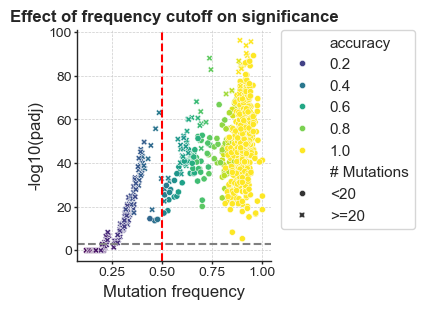

In [10]:
experiment_df = pd.read_csv(f'{data_dir}Experiment4_{label}.csv')
experiment_df['-log10(P.adj)'] = -1*np.log10(experiment_df['P adj.'].values)
experiment_df['Freq'] = [int(c.split('_')[-1]) for c in experiment_df['Plate']]
experiment_df['# Mutations'] = [len(v.split('_')) for v in experiment_df['Variant'].values]
experiment_df['# Mutations'] = [f'<20' if v < 20 else f'>=20' for v in experiment_df['# Mutations']]
experiment_df = experiment_df.reset_index()
experiment_df.replace([np.inf, -np.inf], 320, inplace=True)

ax = sns.scatterplot(experiment_df, x='frequency', y='-log10(P.adj)', hue='accuracy', palette='viridis', 
                     style="# Mutations", style_order=['<20', '>=20'], s=20)
set_ax_params(ax)
plt.xlabel('Mutation frequency')
plt.ylabel('-log10(padj)')
plt.title('Effect of frequency cutoff on significance', fontsize=title_font_size, fontweight="bold")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.axhline(y = significance, color = 'grey', linestyle = '--') #axis='y', 
plt.grid(True, which='major', linestyle='--', linewidth=0.5)
plt.axvline(x = 0.5, color = 'red', linestyle = '--') #axis='y', 
plt.savefig(f'{fig_dir}Experiment4_{label}.svg')
plt.show()

## Experiment 5: ePCR mutation rate

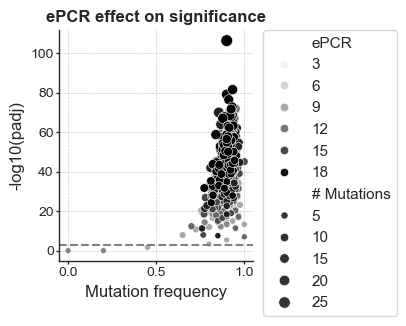

In [11]:
experiment_df = pd.read_csv(f'{data_dir}Experiment5_{label}.csv')
experiment_df['-log10(P.adj)'] = -1*np.log10(experiment_df['P adj.'].values)
experiment_df.replace([np.inf, -np.inf], 320, inplace=True)

experiment_df['ePCR'] = [int(c.split('_')[-1]) for c in experiment_df['Plate']]
experiment_df['# Mutations'] = [len(str(v).split('_')) for v in experiment_df['Variant'].values]
experiment_df = experiment_df.reset_index()
ax = sns.scatterplot(experiment_df, x='frequency', y='-log10(P.adj)', hue='ePCR', palette='Greys', 
                     size="# Mutations")
set_ax_params(ax)
plt.xlabel('Mutation frequency')
plt.ylabel('-log10(padj)')
plt.title('ePCR effect on significance', fontsize=title_font_size, fontweight="bold")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.axhline(y = significance, color = 'grey', linestyle = '--') #axis='y', 
plt.grid(True, which='major', linestyle='--', linewidth=0.5)
plt.savefig(f'{fig_dir}Experiment5_{label}.svg')
plt.show()

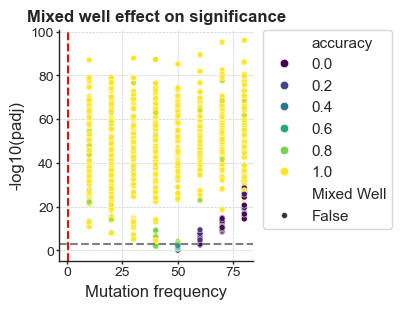

In [12]:
experiment_df = pd.read_csv(f'{data_dir}Experiment6_{label}.csv')

experiment_df['-log10(P.adj)'] = -1*np.log10(experiment_df['P adj.'].values)
experiment_df.replace([np.inf, -np.inf], 320, inplace=True)

experiment_df['mixedWell'] = [int(c.split('_')[-1]) for c in experiment_df['Plate']]
experiment_df['# Mutations'] = [len(str(v).split('_')) for v in experiment_df['Variant'].values]
#experiment_df['# Mutations'] = [f'{v}' if v < 5 else f'>=5' for v in experiment_df['# Mutations']]
experiment_df['Mixed Well'] = [c for c in experiment_df['Mixed Well'].values]

experiment_df = experiment_df.reset_index()
ax = sns.scatterplot(experiment_df, x='mixedWell', y='-log10(P.adj)', hue='accuracy', palette='viridis', 
                     #palette=['grey', 'orange'], 
                     size="Mixed Well")#]# , style_order=['1', '2', '3', '4', '>=5'], s=80)
set_ax_params(ax)
plt.xlabel('Mutation frequency')
plt.ylabel('-log10(padj)')
plt.title('Mixed well effect on significance', fontsize=title_font_size, fontweight="bold")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.axhline(y = significance, color = 'grey', linestyle = '--') #axis='y', 
plt.grid(True, which='major', linestyle='--', linewidth=0.5)
plt.axvline(x = 0.5, color = 'red', linestyle = '--') #axis='y', 

plt.savefig(f'{fig_dir}Experiment6_{label}.svg')
plt.show()

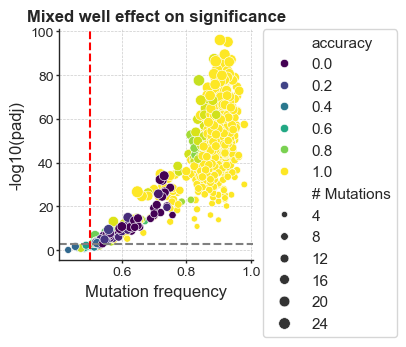

In [13]:
experiment_df = pd.read_csv(f'{data_dir}Experiment6_{label}.csv')

experiment_df['-log10(P.adj)'] = -1*np.log10(experiment_df['P adj.'].values)
experiment_df.replace([np.inf, -np.inf], 320, inplace=True)

experiment_df['mixedWell'] = [int(c.split('_')[-1]) for c in experiment_df['Plate']]
experiment_df['# Mutations'] = [len(str(v).split('_')) for v in experiment_df['Variant'].values]
#experiment_df['# Mutations'] = [f'{v}' if v < 5 else f'>=5' for v in experiment_df['# Mutations']]
experiment_df['Mixed Well'] = [c for c in experiment_df['Mixed Well'].values]

experiment_df = experiment_df.reset_index()
ax = sns.scatterplot(experiment_df, x='frequency', y='-log10(P.adj)', hue='accuracy', palette='viridis', 
                     size="# Mutations")#]# , style_order=['1', '2', '3', '4', '>=5'], s=80)
set_ax_params(ax)
plt.xlabel('Mutation frequency')
plt.ylabel('-log10(padj)')
plt.title('Mixed well effect on significance', fontsize=title_font_size, fontweight="bold")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.axhline(y = significance, color = 'grey', linestyle = '--') #axis='y', 
plt.grid(True, which='major', linestyle='--', linewidth=0.5)
plt.axvline(x = 0.5, color = 'red', linestyle = '--') #axis='y', 

plt.savefig(f'{fig_dir}Experiment6_version2_{label}.svg')
plt.show()

In [14]:
tp, tn, fp, fn = 0, 0, 0, 0
true_mixed_wells = experiment_df['True Mixed Well'].values
labels = []
for i, t in enumerate(experiment_df['Mixed Well'].values):
    if true_mixed_wells[i] and t:
        tp += 1
        labels.append('True positive')
    elif true_mixed_wells[i] and not t:
        fn += 1
        labels.append('False negative')
    elif not true_mixed_wells[i] and not t:
        tn += 1  
        labels.append('True negative')
    elif not true_mixed_wells[i] and t:
        fp += 1
        labels.append('False positive')

    else:
        print(t, true_mixed_wells[i])
tp, tn, fp, fn
print(tp, tn, fp, fn)
acc = (tp + tn)/(tp + tn + fp + fn)
precision = (tp)/(tp + fp)
recall = (tp)/(tp + fn)
acc, precision, recall

0 616 0 152


ZeroDivisionError: division by zero

In [36]:
acc = (tp + tn)/(tp + tn + fp + fn)
precision = (tp)/(tp + fp)
recall = (tp)/(tp + fn)
acc, precision, recall

(0.9231770833333334, 1.0, 0.6040268456375839)

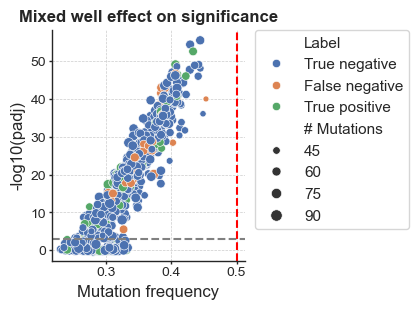

In [37]:
experiment_df['Label'] = labels

ax = sns.scatterplot(experiment_df, x='frequency', y='-log10(P.adj)', hue='Label', 
                     size="# Mutations")#]# , style_order=['1', '2', '3', '4', '>=5'], s=80)
set_ax_params(ax)
plt.xlabel('Mutation frequency')
plt.ylabel('-log10(padj)')
plt.title('Mixed well effect on significance', fontsize=title_font_size, fontweight="bold")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.axhline(y = significance, color = 'grey', linestyle = '--') #axis='y', 
plt.grid(True, which='major', linestyle='--', linewidth=0.5)
plt.axvline(x = 0.5, color = 'red', linestyle = '--') #axis='y', 

plt.savefig(f'{fig_dir}Experiment6_version2_{label}.svg')
plt.show()

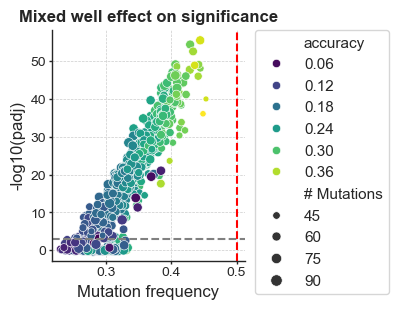

In [38]:
experiment_df = pd.read_csv(f'{data_dir}Experiment6_freq_0.2_{label}.csv')

experiment_df['-log10(P.adj)'] = -1*np.log10(experiment_df['P adj.'].values)
experiment_df.replace([np.inf, -np.inf], 320, inplace=True)

experiment_df['mixedWell'] = [int(c.split('_')[-1]) for c in experiment_df['Plate']]
experiment_df['# Mutations'] = [len(str(v).split('_')) for v in experiment_df['Variant'].values]
#experiment_df['# Mutations'] = [f'{v}' if v < 5 else f'>=5' for v in experiment_df['# Mutations']]
experiment_df['Mixed Well'] = [c for c in experiment_df['Mixed Well'].values]

experiment_df = experiment_df.reset_index()
ax = sns.scatterplot(experiment_df, x='frequency', y='-log10(P.adj)', hue='accuracy', palette='viridis', 
                     size="# Mutations")#]# , style_order=['1', '2', '3', '4', '>=5'], s=80)
set_ax_params(ax)
plt.xlabel('Mutation frequency')
plt.ylabel('-log10(padj)')
plt.title('Mixed well effect on significance', fontsize=title_font_size, fontweight="bold")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.axhline(y = significance, color = 'grey', linestyle = '--') #axis='y', 
plt.grid(True, which='major', linestyle='--', linewidth=0.5)
plt.axvline(x = 0.5, color = 'red', linestyle = '--') #axis='y', 

plt.savefig(f'{fig_dir}Experiment6_version2_{label}.svg')
plt.show()

In [39]:
tp, tn, fp, fn = 0, 0, 0, 0
true_mixed_wells = experiment_df['True Mixed Well'].values
labels = []
for i, t in enumerate(experiment_df['Mixed Well'].values):
    if true_mixed_wells[i] and t:
        tp += 1
        labels.append('True positive')
    elif true_mixed_wells[i] and not t:
        fn += 1
        labels.append('False negative')
    elif not true_mixed_wells[i] and not t:
        tn += 1  
        labels.append('True negative')
    elif not true_mixed_wells[i] and t:
        fp += 1
        labels.append('False positive')

    else:
        print(t, true_mixed_wells[i])
tp, tn, fp, fn
print(tp, tn, fp, fn)
acc = (tp + tn)/(tp + tn + fp + fn)
precision = (tp)/(tp + fp)
recall = (tp)/(tp + fn)
acc, precision, recall

56 613 1 98


(0.87109375, 0.9824561403508771, 0.36363636363636365)

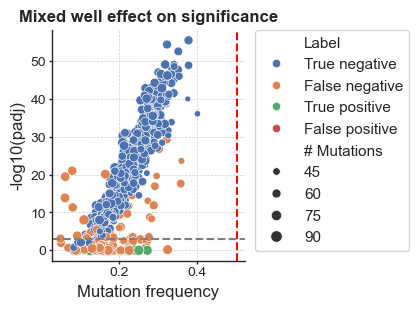

In [17]:
experiment_df['Label'] = labels

ax = sns.scatterplot(experiment_df, x='accuracy', y='-log10(P.adj)', hue='Label', 
                     size="# Mutations")#]# , style_order=['1', '2', '3', '4', '>=5'], s=80)
set_ax_params(ax)
plt.xlabel('Mutation frequency')
plt.ylabel('-log10(padj)')
plt.title('Mixed well effect on significance', fontsize=title_font_size, fontweight="bold")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.axhline(y = significance, color = 'grey', linestyle = '--') #axis='y', 
plt.grid(True, which='major', linestyle='--', linewidth=0.5)
plt.axvline(x = 0.5, color = 'red', linestyle = '--') #axis='y', 

plt.savefig(f'{fig_dir}Experiment6_lowfreq_{label}.svg')
plt.show()

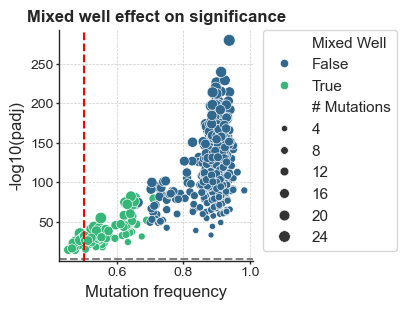

In [40]:
experiment_df = pd.read_csv(f'{data_dir}Experiment6_freq_20_{label}.csv')

experiment_df['-log10(P.adj)'] = -1*np.log10(experiment_df['P adj.'].values)
experiment_df.replace([np.inf, -np.inf], 320, inplace=True)

experiment_df['mixedWell'] = [int(c.split('_')[-1]) for c in experiment_df['Plate']]
experiment_df['# Mutations'] = [len(str(v).split('_')) for v in experiment_df['Variant'].values]
#experiment_df['# Mutations'] = [f'{v}' if v < 5 else f'>=5' for v in experiment_df['# Mutations']]
experiment_df['Mixed Well'] = [c for c in experiment_df['Mixed Well'].values]

experiment_df = experiment_df.reset_index()
ax = sns.scatterplot(experiment_df, x='frequency', y='-log10(P.adj)', hue='Mixed Well', palette='viridis', 
                     size="# Mutations")#]# , style_order=['1', '2', '3', '4', '>=5'], s=80)
set_ax_params(ax)
plt.xlabel('Mutation frequency')
plt.ylabel('-log10(padj)')
plt.title('Mixed well effect on significance', fontsize=title_font_size, fontweight="bold")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.axhline(y = significance, color = 'grey', linestyle = '--') #axis='y', 
plt.grid(True, which='major', linestyle='--', linewidth=0.5)
plt.axvline(x = 0.5, color = 'red', linestyle = '--') #axis='y', 

plt.savefig(f'{fig_dir}Experiment6_freq_20_{label}.svg')
plt.show()

In [41]:
tp, tn, fp, fn = 0, 0, 0, 0
true_mixed_wells = experiment_df['True Mixed Well'].values
for i, t in enumerate(experiment_df['Mixed Well'].values):
    if true_mixed_wells[i] and t:
        tp += 1
    elif true_mixed_wells[i] and not t:
        fn += 1
    elif not true_mixed_wells[i] and not t:
        tn += 1  
    elif not true_mixed_wells[i] and t:
        fp += 1
    else:
        print(t, true_mixed_wells[i])
tp, tn, fp, fn

(90, 619, 0, 59)

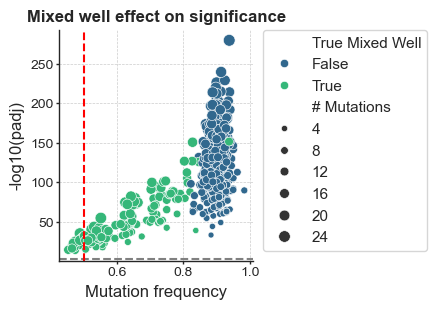

In [42]:
experiment_df = pd.read_csv(f'{data_dir}Experiment6_freq_20_{label}.csv')

experiment_df['-log10(P.adj)'] = -1*np.log10(experiment_df['P adj.'].values)
experiment_df.replace([np.inf, -np.inf], 320, inplace=True)

experiment_df['mixedWell'] = [int(c.split('_')[-1]) for c in experiment_df['Plate']]
experiment_df['# Mutations'] = [len(str(v).split('_')) for v in experiment_df['Variant'].values]
#experiment_df['# Mutations'] = [f'{v}' if v < 5 else f'>=5' for v in experiment_df['# Mutations']]
experiment_df['Mixed Well'] = [c for c in experiment_df['Mixed Well'].values]

experiment_df = experiment_df.reset_index()
ax = sns.scatterplot(experiment_df, x='frequency', y='-log10(P.adj)', hue='True Mixed Well', palette='viridis', 
                     size="# Mutations")#]# , style_order=['1', '2', '3', '4', '>=5'], s=80)
set_ax_params(ax)
plt.xlabel('Mutation frequency')
plt.ylabel('-log10(padj)')
plt.title('Mixed well effect on significance', fontsize=title_font_size, fontweight="bold")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.axhline(y = significance, color = 'grey', linestyle = '--') #axis='y', 
plt.grid(True, which='major', linestyle='--', linewidth=0.5)
plt.axvline(x = 0.5, color = 'red', linestyle = '--') #axis='y', 

plt.savefig(f'{fig_dir}Experiment6_freq_20_{label}.svg')
plt.show()

In [21]:
tp, tn, fp, fn = 0, 0, 0, 0
true_mixed_wells = experiment_df['True Mixed Well'].values
labels = []
for i, t in enumerate(experiment_df['Mixed Well'].values):
    if true_mixed_wells[i] and t:
        tp += 1
        labels.append('True positive')
    elif true_mixed_wells[i] and not t:
        fn += 1
        labels.append('False negative')
    elif not true_mixed_wells[i] and not t:
        tn += 1  
        labels.append('True negative')
    elif not true_mixed_wells[i] and t:
        fp += 1
        labels.append('False positive')

    else:
        print(t, true_mixed_wells[i])
tp, tn, fp, fn

(90, 619, 0, 59)

In [22]:
acc = (tp + tn)/(tp + tn + fp + fn)
acc

0.9231770833333334

In [23]:
acc = (tp + tn)/(tp + tn + fp + fn)
precision = (tp)/(tp + fp)
recall = (tp)/(tp + fn)
acc, precision, recall

(0.9231770833333334, 1.0, 0.6040268456375839)

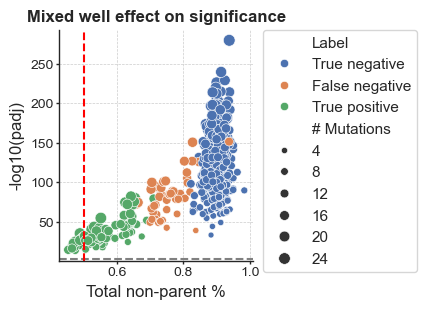

In [25]:
experiment_df = pd.read_csv(f'{data_dir}Experiment6_freq_20_{label}.csv')
experiment_df['Label'] = labels
experiment_df['-log10(P.adj)'] = -1*np.log10(experiment_df['P adj.'].values)
experiment_df.replace([np.inf, -np.inf], 320, inplace=True)

experiment_df['mixedWell'] = [int(c.split('_')[-1]) for c in experiment_df['Plate']]
experiment_df['# Mutations'] = [len(str(v).split('_')) for v in experiment_df['Variant'].values]
#experiment_df['# Mutations'] = [f'{v}' if v < 5 else f'>=5' for v in experiment_df['# Mutations']]
experiment_df['Mixed Well'] = [c for c in experiment_df['Mixed Well'].values]

experiment_df = experiment_df.reset_index()
ax = sns.scatterplot(experiment_df, x='frequency', y='-log10(P.adj)', hue='Label', 
                     size="# Mutations")#]# , style_order=['1', '2', '3', '4', '>=5'], s=80)
set_ax_params(ax)
plt.xlabel('Total non-parent %')
plt.ylabel('-log10(padj)')
plt.title('Mixed well effect on significance', fontsize=title_font_size, fontweight="bold")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.axhline(y = significance, color = 'grey', linestyle = '--') #axis='y', 
plt.grid(True, which='major', linestyle='--', linewidth=0.5)
plt.axvline(x = 0.5, color = 'red', linestyle = '--') #axis='y', 

plt.savefig(f'{fig_dir}Experiment6_freq_20_{label}.svg')
plt.show()

In [26]:
experiment_df

,level_0,index,Plate,Well,Path,Alignment_count,P value,Mixed Well,Variant,mutation,...,P adj.,True Variant,True Mixed Well,correct,incorrect,accuracy,Label,-log10(P.adj),mixedWell,# Mutations
0,0,0,mixedWells_10,Well 0,NaN,20,1.294483e-145,False,C19T_G177C_C191A_G207T_A252C_A330G_G378T_C399A...,NaN,...,4.602607e-145,ATGACTCCCTCGGACATCTCGGGATATGATTATGGGCGTGTCGAGA...,False,14,0,1.0,True negative,144.336996,10,14
1,1,1,mixedWells_10,Well 1,NaN,20,9.189551e-151,False,C15G_G21C_G162T_T164G_G177C_T188A_A215G_G236T_...,NaN,...,3.835639e-150,ATGACTCCCTCGGAGATCCCCGGATATGATTATGGGCGTGTCGAGA...,False,13,0,1.0,True negative,149.416162,10,13
2,2,2,mixedWells_10,Well 2,NaN,20,3.697338e-153,False,C11A_G132A_T133G_C191G_A192C_A244C_G250A_A422G...,NaN,...,1.868129e-152,ATGACTCCCTAGGACATCCCGGGATATGATTATGGGCGTGTCGAGA...,False,15,0,1.0,True negative,151.728593,10,15
3,3,3,mixedWells_10,Well 3,NaN,20,7.529694e-92,False,G23T_T65C_A74T_T225C_G308A_T437G_G477T_A504C_C...,NaN,...,9.638008e-92,ATGACTCCCTCGGACATCCCGGTATATGATTATGGGCGTGTCGAGA...,False,9,0,1.0,True negative,91.016013,10,9
4,4,4,mixedWells_10,Well 4,NaN,20,7.033212e-133,False,C15A_T27A_C42T_G175A_T198G_G207A_G281T_C284G_G...,NaN,...,1.776811e-132,ATGACTCCCTCGGAAATCCCGGGATAAGATTATGGGCGTGTTGAGA...,False,14,0,1.0,True negative,131.750359,10,14
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
763,763,91,mixedWells_80,Well 91,NaN,20,1.349466e-155,False,A46G_A83C_G174A_A247G_G275T_G288T_A289C_A323C_...,NaN,...,5.397866e-155,ATGACTCCCTCGGACATCCCGGGATATGATTATGGGCGTGTCGAGG...,False,14,0,1.0,True negative,154.267778,80,14
764,764,92,mixedWells_80,Well 92,NaN,20,1.273789e-169,False,T25G_C63A_G73C_A158G_G169A_A386C_T423A_A436C_T...,NaN,...,1.111670e-168,ATGACTCCCTCGGACATCCCGGGAGATGATTATGGGCGTGTCGAGA...,False,14,0,1.0,True negative,167.954024,80,14
765,765,93,mixedWells_80,Well 93,NaN,20,2.844558e-101,False,G112T_A145T_G181A_G308C_A345C_T416C_A427T_C518...,NaN,...,4.137539e-101,ATGACTCCCTCGGACATCCCGGGATATGATTATGGGCGTGTCGAGA...,False,9,0,1.0,True negative,100.383258,80,9
766,766,94,mixedWells_80,Well 94,NaN,20,1.882329e-186,False,G35C_T70A_A106C_C227A_G235C_G258T_C302T_T329G_...,NaN,...,3.614071e-185,ATGACTCCCTCGGACATCCCGGGATATGATTATGCGCGTGTCGAGA...,False,18,0,1.0,True negative,184.442003,80,18


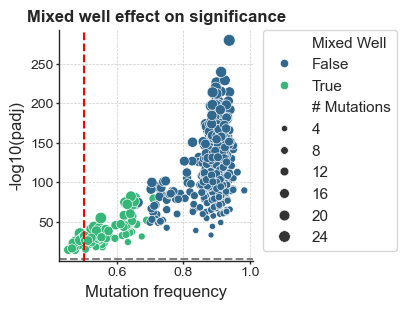

In [27]:
experiment_df = pd.read_csv(f'{data_dir}Experiment6_freq_20_{label}.csv')

experiment_df['-log10(P.adj)'] = -1*np.log10(experiment_df['P adj.'].values)
experiment_df.replace([np.inf, -np.inf], 320, inplace=True)

experiment_df['mixedWell'] = [int(c.split('_')[-1]) for c in experiment_df['Plate']]
experiment_df['# Mutations'] = [len(str(v).split('_')) for v in experiment_df['Variant'].values]
#experiment_df['# Mutations'] = [f'{v}' if v < 5 else f'>=5' for v in experiment_df['# Mutations']]
experiment_df['Mixed Well'] = [c for c in experiment_df['Mixed Well'].values]

experiment_df = experiment_df.reset_index()
ax = sns.scatterplot(experiment_df, x='frequency', y='-log10(P.adj)', hue='Mixed Well', palette='viridis', 
                     size="# Mutations")#]# , style_order=['1', '2', '3', '4', '>=5'], s=80)
set_ax_params(ax)
plt.xlabel('Mutation frequency')
plt.ylabel('-log10(padj)')
plt.title('Mixed well effect on significance', fontsize=title_font_size, fontweight="bold")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.axhline(y = significance, color = 'grey', linestyle = '--') #axis='y', 
plt.grid(True, which='major', linestyle='--', linewidth=0.5)
plt.axvline(x = 0.5, color = 'red', linestyle = '--') #axis='y', 

plt.savefig(f'{fig_dir}Experiment6_freq_20_{label}.svg')
plt.show()

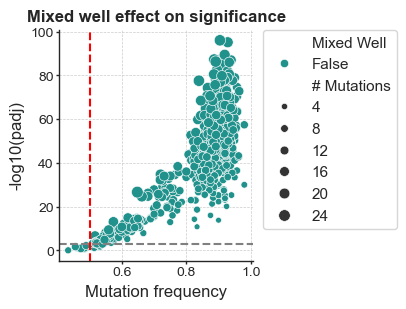

In [28]:
experiment_df = pd.read_csv(f'{data_dir}Experiment6_{label}.csv')

experiment_df['-log10(P.adj)'] = -1*np.log10(experiment_df['P adj.'].values)
experiment_df.replace([np.inf, -np.inf], 320, inplace=True)

experiment_df['mixedWell'] = [int(c.split('_')[-1]) for c in experiment_df['Plate']]
experiment_df['# Mutations'] = [len(str(v).split('_')) for v in experiment_df['Variant'].values]
#experiment_df['# Mutations'] = [f'{v}' if v < 5 else f'>=5' for v in experiment_df['# Mutations']]
experiment_df['Mixed Well'] = [c for c in experiment_df['Mixed Well'].values]

experiment_df = experiment_df.reset_index()
ax = sns.scatterplot(experiment_df, x='frequency', y='-log10(P.adj)', hue='Mixed Well', palette='viridis', 
                     size="# Mutations")#]# , style_order=['1', '2', '3', '4', '>=5'], s=80)
set_ax_params(ax)
plt.xlabel('Mutation frequency')
plt.ylabel('-log10(padj)')
plt.title('Mixed well effect on significance', fontsize=title_font_size, fontweight="bold")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.axhline(y = significance, color = 'grey', linestyle = '--') #axis='y', 
plt.grid(True, which='major', linestyle='--', linewidth=0.5)
plt.axvline(x = 0.5, color = 'red', linestyle = '--') #axis='y', 

plt.savefig(f'{fig_dir}Experiment6_freq_20_{label}.svg')
plt.show()

In [29]:
experiment_df['True Mixed Well']

0       True
1      False
2      False
3      False
4       True
       ...  
763    False
764    False
765    False
766    False
767     True
Name: True Mixed Well, Length: 768, dtype: bool

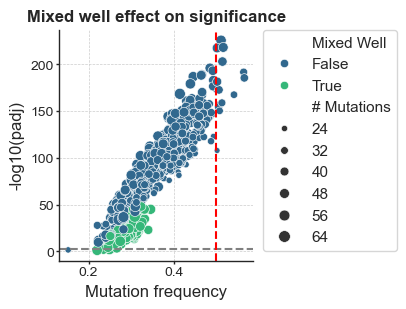

In [30]:
experiment_df = pd.read_csv(f'{data_dir}Experiment6_freq_20_0.2_{label}.csv')

experiment_df['-log10(P.adj)'] = -1*np.log10(experiment_df['P adj.'].values)
experiment_df.replace([np.inf, -np.inf], 320, inplace=True)

experiment_df['mixedWell'] = [int(c.split('_')[-1]) for c in experiment_df['Plate']]
experiment_df['# Mutations'] = [len(str(v).split('_')) for v in experiment_df['Variant'].values]
#experiment_df['# Mutations'] = [f'{v}' if v < 5 else f'>=5' for v in experiment_df['# Mutations']]
experiment_df['Mixed Well'] = [c for c in experiment_df['Mixed Well'].values]

experiment_df = experiment_df.reset_index()
ax = sns.scatterplot(experiment_df, x='frequency', y='-log10(P.adj)', hue='Mixed Well', palette='viridis', 
                     size="# Mutations")#]# , style_order=['1', '2', '3', '4', '>=5'], s=80)
set_ax_params(ax)
plt.xlabel('Mutation frequency')
plt.ylabel('-log10(padj)')
plt.title('Mixed well effect on significance', fontsize=title_font_size, fontweight="bold")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.axhline(y = significance, color = 'grey', linestyle = '--') #axis='y', 
plt.grid(True, which='major', linestyle='--', linewidth=0.5)
plt.axvline(x = 0.5, color = 'red', linestyle = '--') #axis='y', 

plt.savefig(f'{fig_dir}Experiment6_freq_20_0.2_{label}.svg')
plt.show()

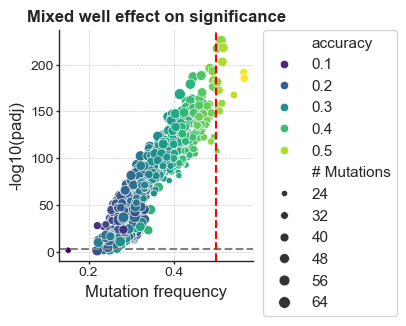

In [31]:
experiment_df = pd.read_csv(f'{data_dir}Experiment6_freq_20_0.2_{label}.csv')

experiment_df['-log10(P.adj)'] = -1*np.log10(experiment_df['P adj.'].values)
experiment_df.replace([np.inf, -np.inf], 320, inplace=True)

experiment_df['mixedWell'] = [int(c.split('_')[-1]) for c in experiment_df['Plate']]
experiment_df['# Mutations'] = [len(str(v).split('_')) for v in experiment_df['Variant'].values]
#experiment_df['# Mutations'] = [f'{v}' if v < 5 else f'>=5' for v in experiment_df['# Mutations']]
experiment_df['Mixed Well'] = [c for c in experiment_df['Mixed Well'].values]

experiment_df = experiment_df.reset_index()
ax = sns.scatterplot(experiment_df, x='frequency', y='-log10(P.adj)', hue='accuracy', palette='viridis', 
                     size="# Mutations")#]# , style_order=['1', '2', '3', '4', '>=5'], s=80)
set_ax_params(ax)
plt.xlabel('Mutation frequency')
plt.ylabel('-log10(padj)')
plt.title('Mixed well effect on significance', fontsize=title_font_size, fontweight="bold")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.axhline(y = significance, color = 'grey', linestyle = '--') #axis='y', 
plt.grid(True, which='major', linestyle='--', linewidth=0.5)
plt.axvline(x = 0.5, color = 'red', linestyle = '--') #axis='y', 

plt.savefig(f'{fig_dir}Experiment6_freq_20_0.2_accuracy_{label}.svg')
plt.show()

/var/folders/sj/4wqsfdtd6093v9746b0t3mq40000gn/T/ipykernel_83058/3157137483.py:12: UserWarning: The palette list has more values (2) than needed (1), which may not be intended.
  ax = sns.scatterplot(experiment_df, x='frequency', y='accuracy', hue='Mixed Well', palette=['grey', 'orange'],


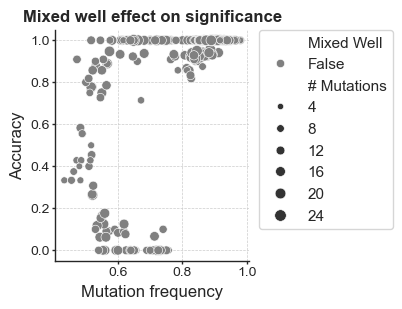

In [32]:
experiment_df = pd.read_csv(f'{data_dir}Experiment6_{label}.csv')

experiment_df['-log10(P.adj)'] = -1*np.log10(experiment_df['P adj.'].values)
experiment_df.replace([np.inf, -np.inf], 320, inplace=True)

experiment_df['mixedWell'] = [int(c.split('_')[-1]) for c in experiment_df['Plate']]
experiment_df['# Mutations'] = [len(str(v).split('_')) for v in experiment_df['Variant'].values]
#experiment_df['# Mutations'] = [f'{v}' if v < 5 else f'>=5' for v in experiment_df['# Mutations']]
experiment_df['Mixed Well'] = [c for c in experiment_df['Mixed Well'].values]

experiment_df = experiment_df.reset_index()
ax = sns.scatterplot(experiment_df, x='frequency', y='accuracy', hue='Mixed Well', palette=['grey', 'orange'], 
                     size="# Mutations")#]# , style_order=['1', '2', '3', '4', '>=5'], s=80)
set_ax_params(ax)
plt.xlabel('Mutation frequency')
plt.ylabel('Accuracy')
plt.title('Mixed well effect on significance', fontsize=title_font_size, fontweight="bold")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.grid(True, which='major', linestyle='--', linewidth=0.5)
plt.savefig(f'{fig_dir}Experiment6_{label}.svg')
plt.show()

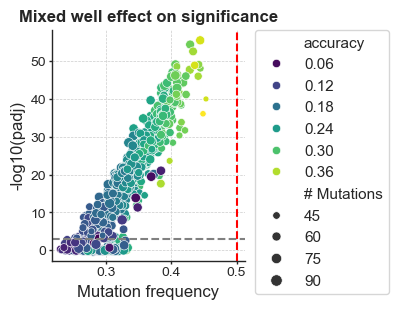

In [33]:
experiment_df = pd.read_csv(f'{data_dir}Experiment6_freq_0.2_{label}.csv')

experiment_df['-log10(P.adj)'] = -1*np.log10(experiment_df['P adj.'].values)
experiment_df.replace([np.inf, -np.inf], 320, inplace=True)

experiment_df['mixedWell'] = [int(c.split('_')[-1]) for c in experiment_df['Plate']]
experiment_df['# Mutations'] = [len(str(v).split('_')) for v in experiment_df['Variant'].values]
#experiment_df['# Mutations'] = [f'{v}' if v < 5 else f'>=5' for v in experiment_df['# Mutations']]
experiment_df['Mixed Well'] = [c for c in experiment_df['Mixed Well'].values]

experiment_df = experiment_df.reset_index()
ax = sns.scatterplot(experiment_df, x='frequency', y='-log10(P.adj)', hue='accuracy', palette='viridis', 
                     size="# Mutations")#]# , style_order=['1', '2', '3', '4', '>=5'], s=80)
set_ax_params(ax)
plt.xlabel('Mutation frequency')
plt.ylabel('-log10(padj)')
plt.title('Mixed well effect on significance', fontsize=title_font_size, fontweight="bold")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.axhline(y = significance, color = 'grey', linestyle = '--') #axis='y', 
plt.grid(True, which='major', linestyle='--', linewidth=0.5)
plt.axvline(x = 0.5, color = 'red', linestyle = '--') #axis='y', 

plt.savefig(f'{fig_dir}Experiment6_freq_0.2_{label}.svg')
plt.show()

In [34]:
print(len(parent_sequence))

612


In [35]:
612*0.02

12.24

In [61]:
plt.hist(experiment_df['# Mutations'].values)